In [1]:
import os
import pandas as pd 
import numpy as np
import sys
import seaborn as sb
import tensorflow as tf 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
## batch specification
batch_size = 40
img_height = 200
img_width = 200


## loading training set
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Rice Seed Dataset',
    validation_split=0.1,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 1032 files belonging to 2 classes.
Using 929 files for training.


In [ ]:
type(training_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'/content/drive/MyDrive/Rice Seed Dataset',
    validation_split=0.25,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)


Found 1032 files belonging to 2 classes.
Using 258 files for validation.


In [ ]:
class_names = training_ds.class_names

In [ ]:
training_ds.as_numpy_iterator

<bound method DatasetV2.as_numpy_iterator of <BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>

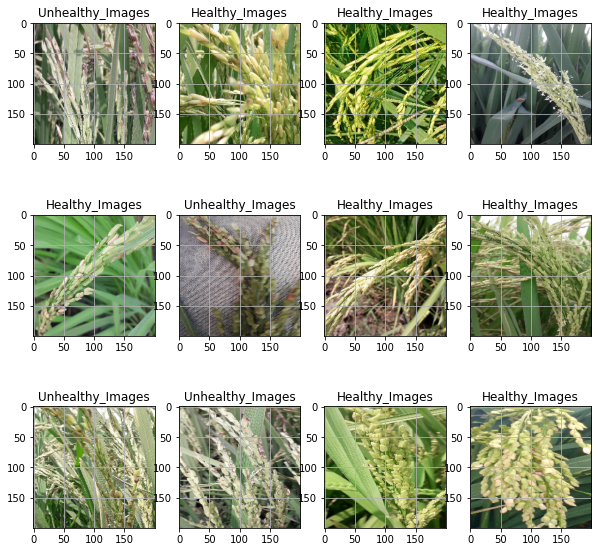

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

Text(0.5, 1.0, 'healthy vs Unhealthy samples in data set')

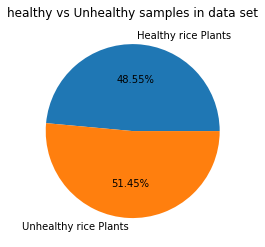

In [ ]:
## healthy vs unhealthy samples in data set
healthy = os.listdir('/content/drive/MyDrive/Rice Seed Dataset/Healthy_Images')
unhealthy = os.listdir('/content/drive/MyDrive/Rice Seed Dataset/Unhealthy_Images')
plt.pie ([len(healthy), len(unhealthy)], labels = ['Healthy rice Plants', 
                                                                      'Unhealthy rice Plants'],autopct='%1.2f%%')
plt.title('healthy vs Unhealthy samples in data set')

In [ ]:
## defining data augumentation layer
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  
])

In [ ]:
## ## lets define our CNN
MyCnn = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(100, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(60, 3, activation='relu'),
  layers.Conv2D(30, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(120, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(1, activation= 'sigmoid')
])

In [ ]:
MyCnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
## rescheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
## training our model 
retVal = MyCnn.fit(training_ds, validation_data= testing_ds,callbacks=[callback], epochs = 14)

Epoch 1/14
24/24 [==============================] - 30s 924ms/step - loss: 0.6911 - accuracy: 0.5274 - val_loss: 0.7245 - val_accuracy: 0.4341 - lr: 1.0000e-04
Epoch 2/14
24/24 [==============================] - 28s 871ms/step - loss: 0.6639 - accuracy: 0.5888 - val_loss: 0.6461 - val_accuracy: 0.6202 - lr: 1.0000e-04
Epoch 3/14
24/24 [==============================] - 28s 869ms/step - loss: 0.6481 - accuracy: 0.6222 - val_loss: 0.6520 - val_accuracy: 0.6202 - lr: 1.0000e-04
Epoch 4/14
24/24 [==============================] - 28s 864ms/step - loss: 0.6190 - accuracy: 0.6426 - val_loss: 0.5949 - val_accuracy: 0.6860 - lr: 1.0000e-04
Epoch 5/14
24/24 [==============================] - 28s 863ms/step - loss: 0.5925 - accuracy: 0.6868 - val_loss: 0.5723 - val_accuracy: 0.7287 - lr: 1.0000e-04
Epoch 6/14
24/24 [==============================] - 28s 870ms/step - loss: 0.5175 - accuracy: 0.7513 - val_loss: 0.5696 - val_accuracy: 0.6822 - lr: 9.0484e-05
Epoch 7/14
24/24 [======================

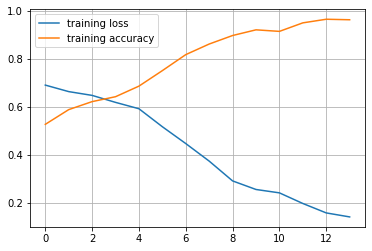

In [ ]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()
plt.grid(True)

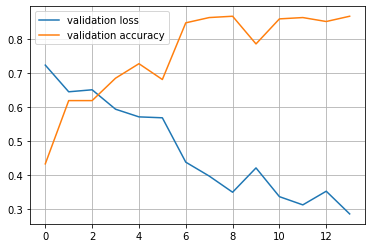

In [ ]:
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.grid(True)

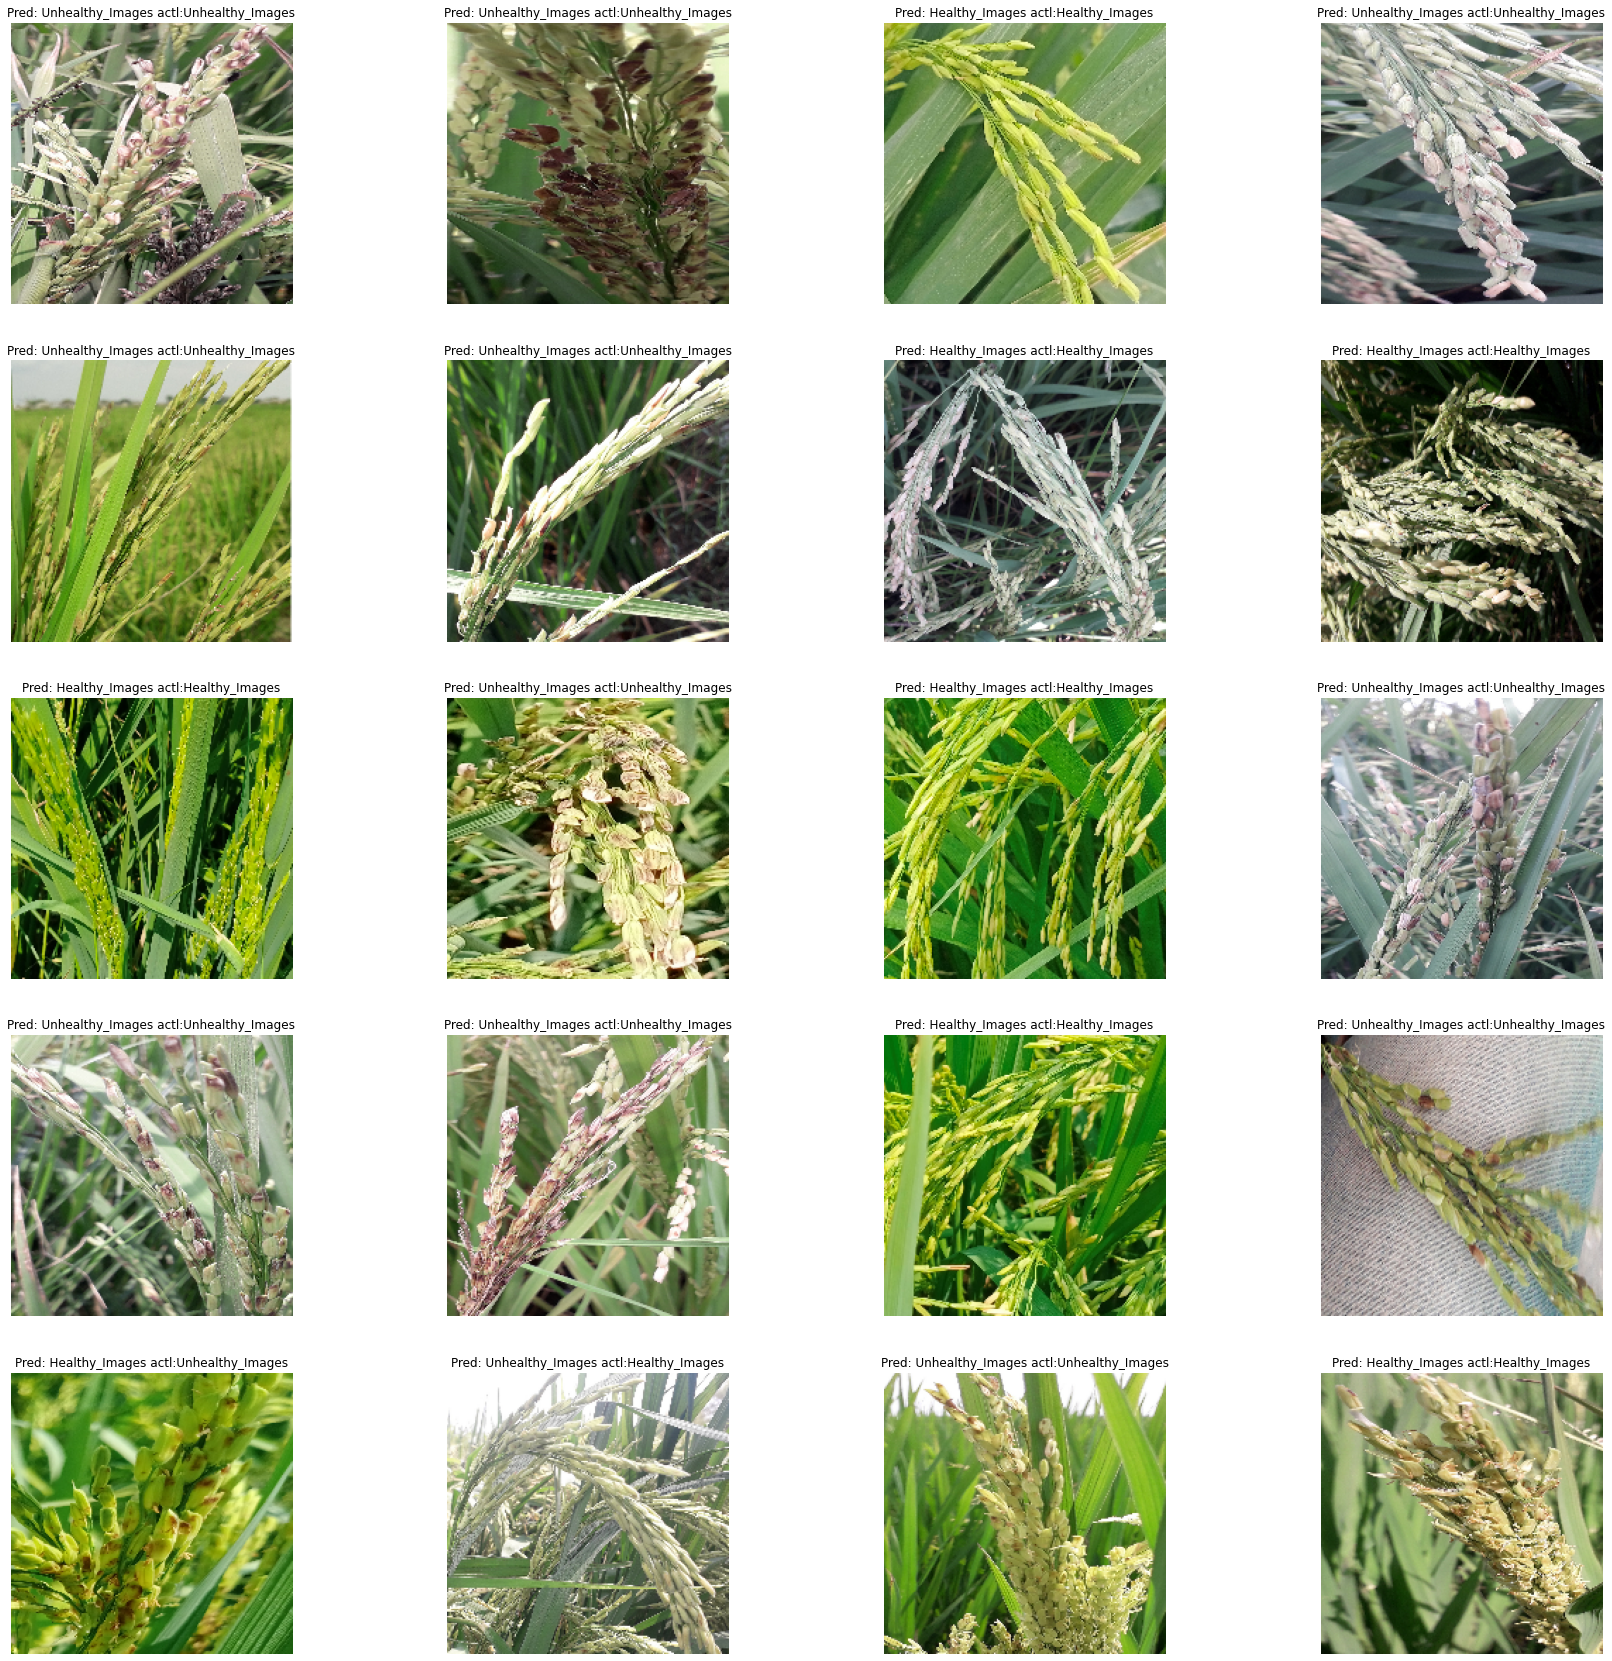

In [ ]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[int (round(mem[0]))])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

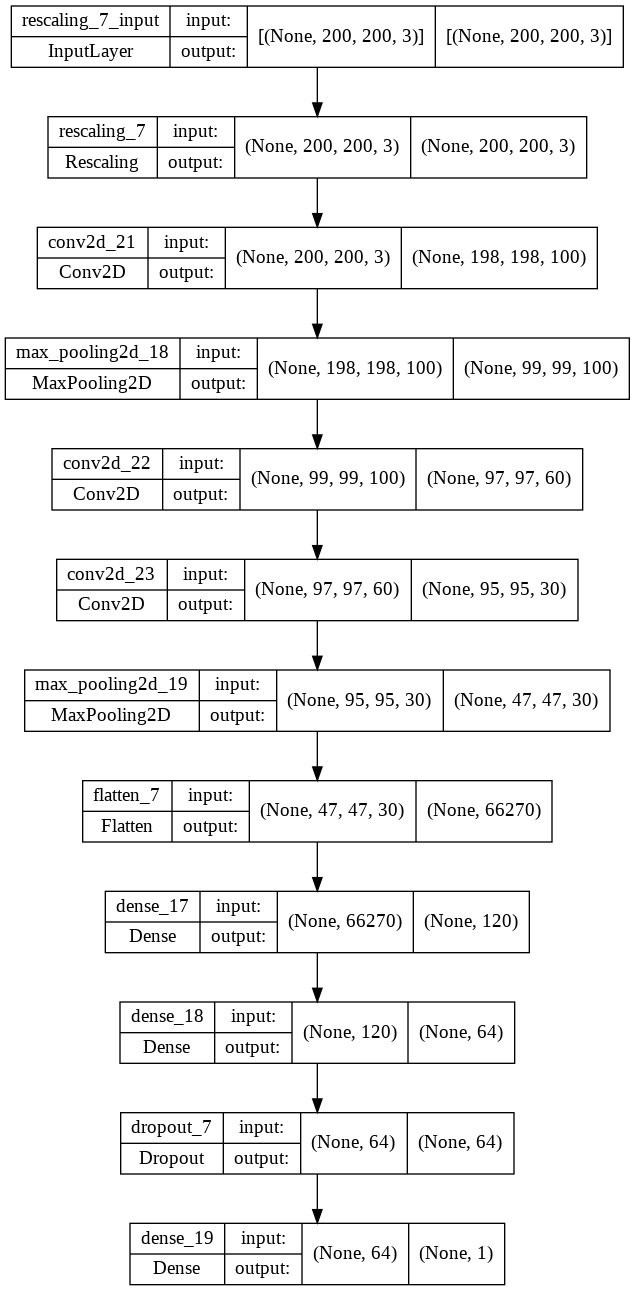

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(MyCnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
MyCnn.save('model_86.h5')

Now applying Resnet model on the same dataset

In [17]:
train_Path = '/content/drive/MyDrive/Rice Seed Dataset'
test_Path = '/content/drive/MyDrive/Test'

In [3]:
IMAGE_SIZE = [224, 224]

In [4]:
resnet = ResNet50(
    input_shape = IMAGE_SIZE + [3], # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   # 
)

94781440/94765736 [==============================] - 0s 0us/step


In [5]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [7]:
for layer in resnet.layers:
    layer.trainable = False
    

In [8]:
folders = glob(train_Path + '/*')
folders

['/content/drive/MyDrive/Rice Seed Dataset/Healthy_Images',
 '/content/drive/MyDrive/Rice Seed Dataset/Unhealthy_Images']

In [9]:
x = Flatten() (resnet.output)

In [10]:
prediction = Dense(len(folders), activation = 'softmax')(x)

In [11]:
model = Model(inputs = resnet.input, outputs = prediction)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [18]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [19]:
training_set = train_datagen.flow_from_directory(
    train_Path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical' # As we have more than 2 so using categorical.. for 2 we might have used binary.
)
test_set = train_datagen.flow_from_directory(
    test_Path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1032 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [20]:
history = model.fit_generator(
    training_set,
    validation_data = test_set,
    epochs = 15,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
33/33 [==============================] - 304s 9s/step - loss: 2.7990 - accuracy: 0.4971 - val_loss: 0.5644 - val_accuracy: 0.7449
Epoch 2/15
33/33 [==============================] - 94s 3s/step - loss: 0.8681 - accuracy: 0.5688 - val_loss: 1.1782 - val_accuracy: 0.5000
Epoch 3/15
33/33 [==============================] - 93s 3s/step - loss: 1.0269 - accuracy: 0.5698 - val_loss: 0.7333 - val_accuracy: 0.6224
Epoch 4/15
33/33 [==============================] - 92s 3s/step - loss: 0.8249 - accuracy: 0.5921 - val_loss: 0.6765 - val_accuracy: 0.6122
Epoch 5/15
33/33 [==============================] - 92s 3s/step - loss: 0.7892 - accuracy: 0.6172 - val_loss: 0.8964 - val_accuracy: 0.5408
Epoch 6/15
33/33 [==============================] - 92s 3s/step - loss: 0.6573 - accuracy: 0.6473 - val_loss: 0.6935 - val_accuracy: 0.6224
Epoch 7/15
33/33 [==============================] - 92s 3s/step - loss: 0.8032 - accuracy: 0.6056 - val_loss: 1.0744 - val_accuracy: 0.5102
Epoch 8/15
33/33 [=

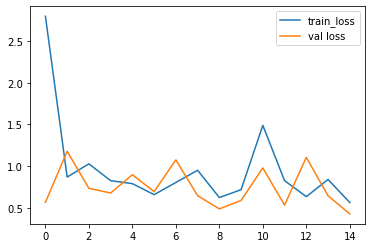

In [21]:
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

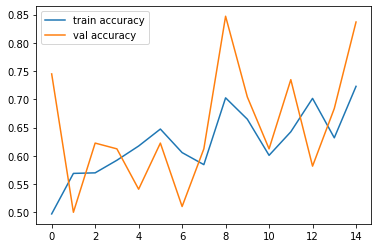

In [22]:
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()

In [24]:
model.save('resnet_model.h5')